In [131]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching oil data from yahoo finance
data = yf.Ticker('CL=F')
data = yf.download('CL=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

#data

[*********************100%%**********************]  1 of 1 completed


In [132]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
#data

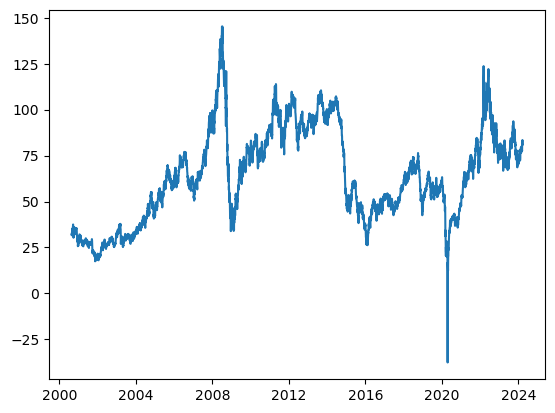

In [133]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [134]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [135]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

#any greater window causes severe overfitting
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
#shifted_df

In [136]:
shifted_df_as_np = shifted_df.to_numpy()

#shifted_df_as_np

In [137]:
shifted_df_as_np.shape

(5914, 8)

In [138]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

#shifted_df_as_np

In [139]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5914, 7), (5914,))

In [140]:
X = dc(np.flip(X, axis=1))
#X

In [141]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5618

In [142]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5618, 7), (296, 7), (5618,), (296,))

In [143]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5618, 7, 1), (296, 7, 1), (5618, 1), (296, 1))

In [144]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5618, 7, 1]),
 torch.Size([296, 7, 1]),
 torch.Size([5618, 1]),
 torch.Size([296, 1]))

In [145]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [146]:
train_dataset

In [147]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [148]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [149]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
model = LSTM(1, 4, 1) #MAPE :1.989
#model = LSTM(1, 8, 2) MAPE :2.178
#model = LSTM(1, 16, 4) MAPE :2.44
#model = LSTM(1, 4, 2) MAPE : 2.528
#model = LSTM(1, 2, 1) MAPE : 2.13
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [150]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [151]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [152]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
#20 epochs caused massive overfitting for the dataset size
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.076
Batch 200, Loss: 0.048
Batch 300, Loss: 0.011

Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.000
*****************

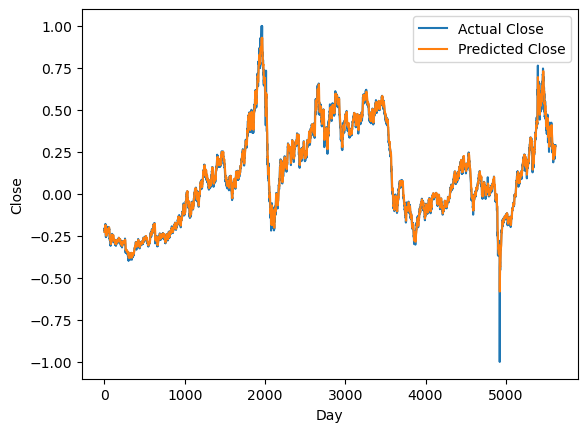

In [153]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [154]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([33.1832507 , 33.35881435, 33.64503134, ..., 78.76743961,
       79.61302892, 79.77256261])

In [155]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([33.38000137, 33.79999944, 34.95000129, ..., 80.18000055,
       79.48000287, 80.3300024 ])

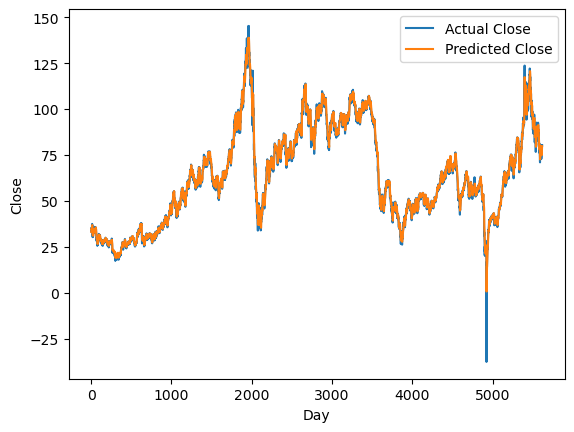

In [156]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [157]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
#test_predictions

In [158]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
#new_y_test

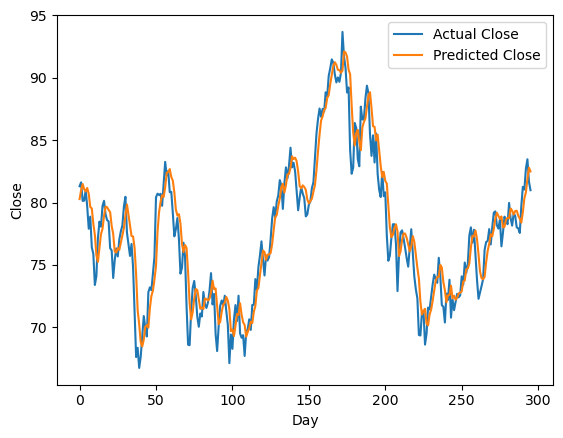

In [159]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [160]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 1.9052510740863264
Mean Absolute Error (MAE): 1.4782945452578036
Mean Absolute Percentage Error (MAPE): 1.9337270620629405


In [161]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.022, MAE: 0.014, MAPE: 1896.963%
Validation - RMSE: 0.021, MAE: 0.016, MAPE: 6.848%


In [162]:
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
prediction = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted oil price for tomorrow: {prediction}')


Predicted oil price for tomorrow: 79.78932306097084
